In [1]:
using Revise
using FUSE
using Plots;
FUSE.logging(Logging.Info; actors=Logging.Info);


Precompiling FUSE
  ✓ FUSE
  1 dependency successfully precompiled in 77 seconds. 599 already precompiled.


In [11]:
# sty is the act equivalent for a study, it has common parameters like server and n_workers but also study dependent parameters like TGLF saturation rules
sty,act = FUSE.study_parameters(:TGLFdb);
sty

ParametersStudyTGLFdb{Real}
├─ server{String} ➡ "localhost" Where to run ["localhost", "omega", "saga"]
├─ n_workers{Int64} ➡ missing Number of workers to run with
├─ file_save_mode{Symbol} ➡ :safe_write Saving file policy, `safe_write` only writes when the folder is empty [:safe_write,
│  :overwrite]
├─ release_workers_after_run{Bool} ➡ true Releases the workers after running the study
├─ save_dd{Bool} ➡ true Save dd of the study to save folder
├─ sat_rules{Vector{Symbol}} ➡ missing TGLF saturation rules to run
├─ lump_ions{Bool} ➡ true Lumps the fuel species (D,T) as well as the impurities together
├─ custom_tglf_models{Vector{String}} ➡ missing This will run custom TGLFNN models stored in TGLFNN/models
├─ save_folder{String} ➡ missing Folder to save the database runs into
└─ database_folder{String} ➡ missing Folder with input database


In [12]:
# Interacting with sty
sty.server = "localhost"
sty.n_workers = 10

sty.database_folder = "/mnt/beegfs/users/neisert/ODSs/iri/166066" #166066" #mastu_test" #d3d_negDcake_oak"#"/mnt/beegfs/users/neisert/ODSs/mastu"

sty.save_folder = "/mnt/beegfs/users/neisert/ODSs/iri/166066/outputs_gknn_rho_0p05_0p02_0p85_rot" #"/mnt/beegfs/users/neisert/ODSs/mastu/outputs_sat1_es_d3d"
sty.sat_rules = missing #[:sat2]#,:sat1,:sat2,:sat3] #study specific parameters
# It's also possible to run with a custom tglfnn model, set sty.custom_tglf_models
sty.custom_tglf_models = ["sat2_em_d3d_azf+1","sat3_em_d3d_azf+1","sat2_em_d3d_azf-1","sat3_em_d3d_azf-1"]
sty.file_save_mode = :overwrite
sty.release_workers_after_run = true # this is the default behavior and releases workers after running the study
sty

ParametersStudyTGLFdb{Real}
├─ server{String} ➡ "localhost" Where to run ["localhost", "omega", "saga"]
├─ n_workers{Int64} ➡ 10 Number of workers to run with
├─ file_save_mode{Symbol} ➡ :overwrite Saving file policy, `safe_write` only writes when the folder is empty [:safe_write,
│  :overwrite]
├─ release_workers_after_run{Bool} ➡ true Releases the workers after running the study
├─ save_dd{Bool} ➡ true Save dd of the study to save folder
├─ sat_rules{Vector{Symbol}} ➡ missing TGLF saturation rules to run
├─ lump_ions{Bool} ➡ true Lumps the fuel species (D,T) as well as the impurities together
├─ custom_tglf_models{Vector{String}} ➡ ["sat2_em_d3d_azf+1", "sat3_em_d3d_azf+1", "sat2_em_d3d_azf-1", "sat3_em_d3d_azf-1"]
│  This will run custom TGLFNN models stored in TGLFNN/models
├─ save_folder{String} ➡ "/mnt/beegfs/users/neisert/ODSs/iri/166066/outputs_gknn_rho_0p05_0p02_0p85_rot" Folder to save the
│  database runs into
└─ database_folder{String} ➡ "/mnt/beegfs/users/neisert/ODSs/iri/

In [13]:
# study is the actor equivalent of actors, here sty, act and outputs are kept of the workflow
study = FUSE.StudyTGLFdb(sty, act; n_workers=10); # it is possible to pass in keyword arguments to sty

# instantiating the study will also setup the study i.e. FUSE.setup(study);

Working with 10 workers on saga.cluster


In [14]:
# for now you will have to import FUSE everywhere in your distributed computing
using Distributed
@everywhere import FUSE


In [15]:
# The filename you provided
#=filename = "/mnt/beegfs/users/neisert/ODSs/d3d_negDcake_oak/fuse_prepared_inputs/ods_193899_2810.json"

timefn = match(r"(\d+)\.\w+$", filename)
if timefn !== nothing
    timef = timefn.captures[1]
else
    timef = 0
end
println("$timef")
# Alternative regular expression to capture numbers
alternative_match = match(r"(\d+)\.json$", filename)

if alternative_match !== nothing
    # Extract the number
    alternative_number = parse(Int, alternative_match.captures[1])
    println("Alternative match found: ", alternative_number)
else
    println("Alternative match not found.")
end
=#

In [16]:
study.act.ActorFluxMatcher.evolve_rotation = :flux_match
study.act.ActorFluxMatcher.rho_transport = 0.05:0.02:0.85
# density is evolved now by default with impurities fixed
#=study.act.ActorFluxMatcher.evolve_densities = Dict(
    :D        => :quasi_neutrality,
    :D_fast   => :fixed,
    :C        => :fixed,
    :electrons => :flux_match)
=#
study.act.ActorFluxMatcher

ActorFluxMatcher{Float64}
├─ rho_transport{AbstractVector{Float64}} ➡ 0.05:0.02:0.85 ρ transport grid
├─ evolve_Ti{Symbol} ➡ :flux_match Ion temperature `:flux_match` or keep `:fixed` [:flux_match, :fixed]
├─ evolve_Te{Symbol} ➡ :flux_match Electron temperature `:flux_match` or keep `:fixed` [:flux_match, :fixed]
├─ evolve_densities{Union{Symbol, AbstractDict}} ➡ :fixed Densities `:fixed`, or electron flux-match and rest match ne
│  scale `:flux_match`, or Dict to specify which species are `:flux_match`, kept `:fixed`, used to enforce
│  `:quasi_neutrality`, or scaled to `:match_ne_scale`
├─ evolve_rotation{Symbol} ➡ :flux_match Rotation `:flux_match` or keep `:fixed` [:flux_match, :fixed]
├─ evolve_pedestal{Bool} ➡ false Evolve the pedestal inside the transport solver
├─ find_widths{Bool} ➡ true Runs Turbulent transport actor TJLF finding widths after first iteration
├─ max_iterations{Int64} ➡ 300 Maximum optimizer iterations
├─ optimizer_algorithm{Symbol} ➡ :anderson Optimizing algor

In [17]:
FUSE.run(study);   # runs the study, this also writes the dataframes

# at the end of the run workers are released so you will have to setup again if you want to run more

Running StudyTGLFdb on 39 cases on ["sat2_em_d3d_azf+1", "sat3_em_d3d_azf+1", "sat2_em_d3d_azf-1", "sat3_em_d3d_azf-1"] with 10 workers on localhost
      From worker 14:	┌ Warning: equilibrium.time_slice[1].profiles_1d.centroid was skipped in dict2imas
      From worker 14:	└ @ IMASDD ~/.julia/dev/IMASDD/src/io.jl:138
      From worker 21:	┌ Warning: equilibrium.time_slice[1].profiles_1d.centroid was skipped in dict2imas
      From worker 21:	└ @ IMASDD ~/.julia/dev/IMASDD/src/io.jl:138
      From worker 17:	┌ Warning: equilibrium.time_slice[1].profiles_1d.centroid was skipped in dict2imas
      From worker 17:	└ @ IMASDD ~/.julia/dev/IMASDD/src/io.jl:138
      From worker 21:	┌ Warning: core_profiles.profiles_1d[1].ion[2].rotation was skipped in dict2imas
      From worker 21:	└ @ IMASDD ~/.julia/dev/IMASDD/src/io.jl:138
      From worker 14:	┌ Warning: core_profiles.profiles_1d[1].ion[2].rotation was skipped in dict2imas
      From worker 14:	└ @ IMASDD ~/.julia/dev/IMASDD/src/io.jl

[ Info: released workers


In [18]:
# data for this workflow is stored in a dictionary of dataframes study.dataframes_dict
#study.dataframes_dict[:sat1]
#study.dataframes_dict["sat1_es_d3d"]

study.dataframes_dict["sat2_em_d3d_azf+1","sat3_em_d3d_azf+1","sat2_em_d3d_azf-1","sat3_em_d3d_azf-1"]

LoadError: KeyError: key ("sat2_em_d3d_azf+1", "sat3_em_d3d_azf+1", "sat2_em_d3d_azf-1", "sat3_em_d3d_azf-1") not found

MRE SAT2 EM D3D AZF+1 W_thermal = NaN % with N = 0


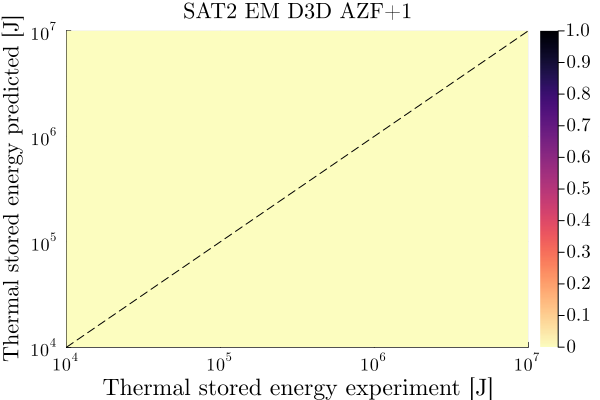

MRE SAT3 EM D3D AZF+1 W_thermal = NaN % with N = 0


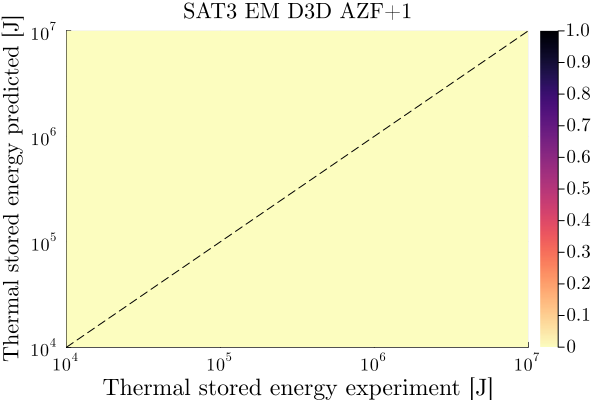

MRE SAT2 EM D3D AZF-1 W_thermal = NaN % with N = 0


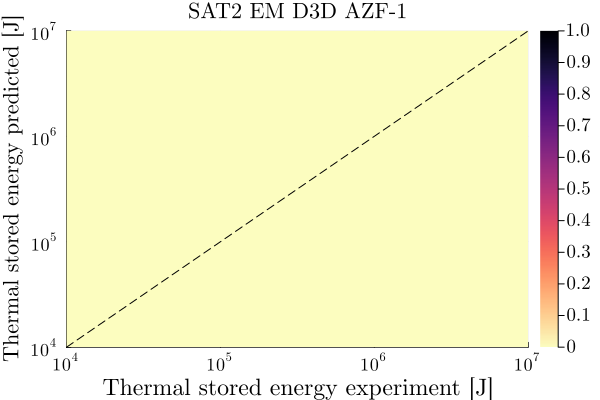

MRE SAT3 EM D3D AZF-1 W_thermal = NaN % with N = 0


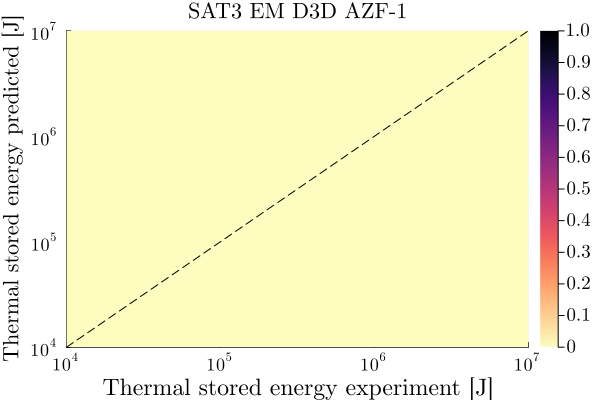

In [19]:
# analyze the study results 
FUSE.analyze(study);